# Proyecto 2 | Fashion-MNIST

## Fase 1 · Preparación del entorno y carga de datos
Objetivo: tener los datos listos y limpios. Según el enunciado, esta fase incluye:
- Configurar entorno (Jupyter + librerías).
- Cargar Fashion-MNIST.
- Preprocesar: normalizar [0,1] y separar en conjuntos (train/val, dejando test intacto). 


In [ ]:
from pathlib import Path
import numpy as np, struct

BASE = Path(r"C:\Users\josea\Desktop\Machine Learning\proyecto 2") #acá coloquen la dirección del proyecto

def load_idx_images(p):
    with open(p, "rb") as f:
        magic, n, rows, cols = struct.unpack(">IIII", f.read(16))
        assert magic == 2051
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(n, rows*cols)

def load_idx_labels(p):
    with open(p, "rb") as f:
        magic, n = struct.unpack(">II", f.read(8))
        assert magic == 2049
        return np.frombuffer(f.read(), dtype=np.uint8)

train_X = load_idx_images(BASE/"train_X").astype("float32")/255.0
test_X  = load_idx_images(BASE/"test_X").astype("float32")/255.0
train_y = load_idx_labels(BASE/"train_Y").astype(int)
test_y  = load_idx_labels(BASE/"test_Y").astype(int)

print("Train:", train_X.shape, train_y.shape)
print("Test :", test_X.shape,  test_y.shape)


Train: (60000, 784) (60000,)
Test : (10000, 784) (10000,)


### Split de validación (80/20, estratificado)
Uso un conjunto de validación separado del test oficial para comparar modelos sin sesgo.

In [8]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    train_X, train_y, test_size=0.2, random_state=42, stratify=train_y
)
X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((48000, 784), (12000, 784), (48000,), (12000,))

## Fase 2 · Reducción de dimensionalidad
Lo que piden: implementar métodos lineales (PCA, NMF), no lineales (t-SNE, UMAP) y explorar Spectral Embedding/Isomap. 
Además, generar visualizaciones 2D por clase. 

### Funciones y Mestreo
Para que los gráficos no tarden una eternidad, muestreamos un subconjunto (10k puntos).
Definimos una función de ploteo consistente y fijo semilla para reproducibilidad.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def sample_xy(X, y, n=10000, random_state=RANDOM_STATE):
    if len(X) <= n:
        return X, y
    idx = np.random.RandomState(random_state).choice(len(X), size=n, replace=False)
    return X[idx], y[idx]

def plot_embedding(Z, y, title, s=2):
    plt.figure(figsize=(6,6))
    plt.scatter(Z[:,0], Z[:,1], c=y, s=s)
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.tight_layout(); plt.show()

# Subconjunto para visualizaciones 2D
X_vis, y_vis = sample_xy(train_X, train_y, n=10000, random_state=RANDOM_STATE)
X_vis.shape, y_vis.shape

((10000, 784), (10000,))

## 2.1 Métodos lineales: PCA y NMF

Los métodos lineales buscan transformar el espacio original (784 variables) a un espacio más 
compacto **preservando la mayor cantidad posible de información** (varianza o estructura).

### A) PCA (Análisis de Componentes Principales)
- Busca direcciones ortogonales (componentes) que **maximizan la varianza total** de los datos.
- No usa etiquetas: es un método **no supervisado**.
- Cada componente explica un porcentaje de la varianza del conjunto original.
- Se puede determinar el número óptimo de componentes observando la curva de **varianza acumulada**.

### B) NMF (Non-negative Matrix Factorization)
- Descompone `X ≈ W·H` con `W,H ≥ 0`, lo que genera una representación **aditiva y más interpretativa**.
- Cada componente representa una "base" que combina partes de las imágenes originales.
- Es útil cuando los datos no negativos (como pixeles [0,1]) y se quiere preservar interpretabilidad.
- El número de componentes puede elegirse observando la **reconstrucción del error** o hasta dónde mejora el modelo sin sobrecoste.


### PCA: varianza explicada por componentes
Analizamos cuánta varianza del dataset se conserva con diferente número de componentes.
Esto permite justificar por qué usar 50 componentes en lugar de 100 o 150.


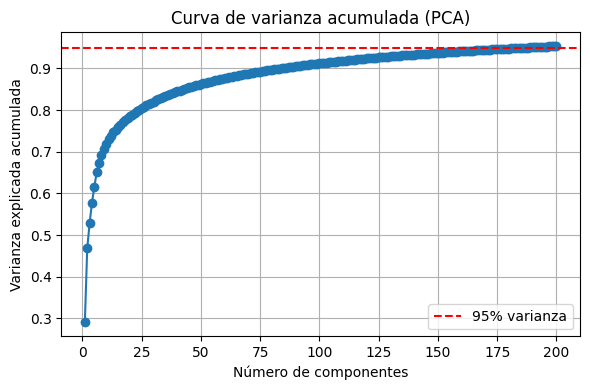

Componentes necesarios para retener 95% de la varianza: 188


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Entrenamos PCA con todos los componentes posibles (limitamos a 200 por tiempo)
pca_full = PCA(n_components=200, random_state=RANDOM_STATE)
pca_full.fit(train_X)

# Varianza explicada individual y acumulada
var_exp = pca_full.explained_variance_ratio_
cum_var = np.cumsum(var_exp)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1,201), cum_var, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Curva de varianza acumulada (PCA)')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Determinamos el número mínimo de componentes que retiene 95% de varianza
n_95 = np.argmax(cum_var >= 0.95) + 1
print(f"Componentes necesarios para retener 95% de la varianza: {n_95}")

### NMF: error de reconstrucción
El NMF no se evalúa por varianza sino por error de reconstrucción ||X - W·H||.
A medida que aumentan los componentes, el error baja, pero llega un punto de rendimientos decrecientes.
Probamos varios valores (10–100) para ver dónde se estabiliza.

C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


Componentes=10, error=0.026670


C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


Componentes=20, error=0.021224


C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


Componentes=30, error=0.018215


C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


Componentes=50, error=0.014540


C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


Componentes=80, error=0.011253
Componentes=100, error=0.009848


C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


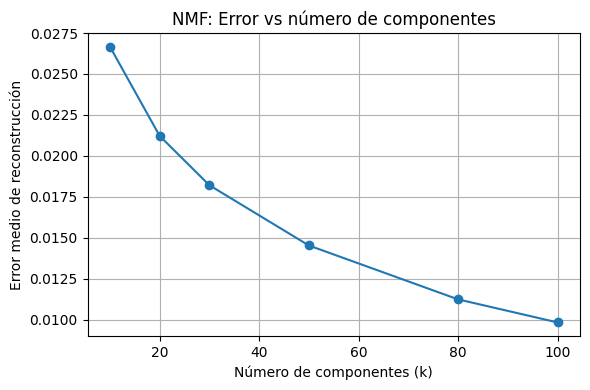

In [18]:
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt

# Tomamos una muestra reducida por velocidad
idx = np.random.choice(len(train_X), size=5000, replace=False)
X_sample = train_X[idx]

components_list = [10, 20, 30, 50, 80, 100]
errors = []

for k in components_list:
    nmf = NMF(n_components=k, init='nndsvda', max_iter=300, random_state=42)
    W = nmf.fit_transform(X_sample)
    H = nmf.components_
    recon = np.dot(W, H)
    err = np.mean((X_sample - recon) ** 2)
    errors.append(err)
    print(f"Componentes={k}, error={err:.6f}")

plt.figure(figsize=(6,4))
plt.plot(components_list, errors, marker='o')
plt.xlabel("Número de componentes (k)")
plt.ylabel("Error medio de reconstrucción")
plt.title("NMF: Error vs número de componentes")
plt.grid(True); plt.tight_layout(); plt.show()

### Comparación visual PCA vs NMF en 2D
Ambos reducen de 784 a 2 dimensiones para visualizar agrupamientos.
El PCA tiende a mostrar ejes ortogonales suaves; NMF agrupa de forma más segmentada.

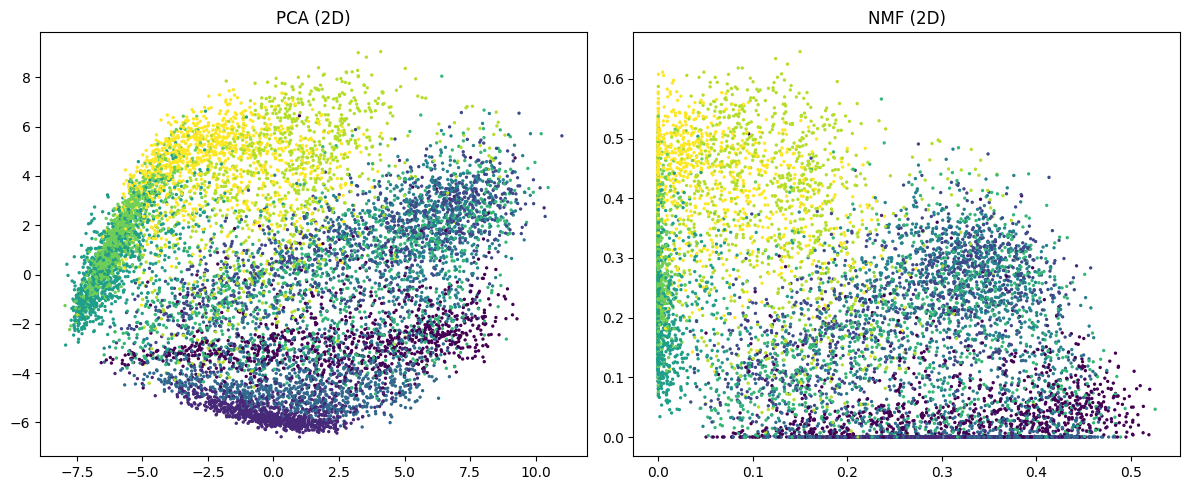

In [19]:
# PCA 2D
pca2 = PCA(n_components=2, random_state=42).fit(train_X)
Z_pca2 = pca2.transform(train_X[:10000])

# NMF 2D
nmf2 = NMF(n_components=2, init='nndsvda', random_state=42, max_iter=300)
Z_nmf2 = nmf2.fit_transform(train_X[:10000])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(Z_pca2[:,0], Z_pca2[:,1], c=train_y[:10000], s=2)
plt.title("PCA (2D)")

plt.subplot(1,2,2)
plt.scatter(Z_nmf2[:,0], Z_nmf2[:,1], c=train_y[:10000], s=2)
plt.title("NMF (2D)")
plt.tight_layout(); plt.show()


### Resultados y elección de parámetros (métodos lineales)

| Método | Criterio evaluado | Observación | Configuración adoptada |
|:-------|:------------------|:-------------|:------------------------|
| **PCA** | Varianza acumulada | 95 % varianza a 188 comp. / 88 % a 50 comp. | 50 componentes (eficiencia) |
| **NMF** | Error de reconstrucción | Error se estabiliza ≈50 comp. | 50 componentes (error ≈ 0.013) |

**Decisión:** usaremos 50 componentes para ambos métodos como base en la Fase 3. 
Esta dimensionalidad reduce ~94 % de las variables originales con mínima pérdida de información, acelerando el entrenamiento de los clasificadores.

## 2.2 Métodos no lineales: t-SNE y UMAP

Estos métodos buscan preservar **relaciones de vecindad** (estructura local) en lugar de la varianza global:

- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**:
  Transforma distancias euclidianas en probabilidades de vecindad y reduce dimensiones minimizando
  la divergencia de Kullback-Leibler. Produce agrupamientos claros pero **no generaliza fuera del conjunto entrenado**
  y su coste crece cuadráticamente con el número de muestras.
  Parámetros clave:
  - `perplexity`: equilibrio entre estructura local y global (20–50 típico).
  - `n_iter`: número de iteraciones de optimización (1000–2000).

- **UMAP (Uniform Manifold Approximation and Projection)**:
  Construye un grafo de vecinos y preserva su topología mediante un modelo de manifold continuo.
  Es más rápido que t-SNE y puede **generalizar transformaciones** (`.transform()`).
  Parámetros clave:
  - `n_neighbors`: controla cuán local/global es la proyección.
  - `min_dist`: controla la compacidad de los clústeres (0 → compactos, 0.5 → más dispersos).

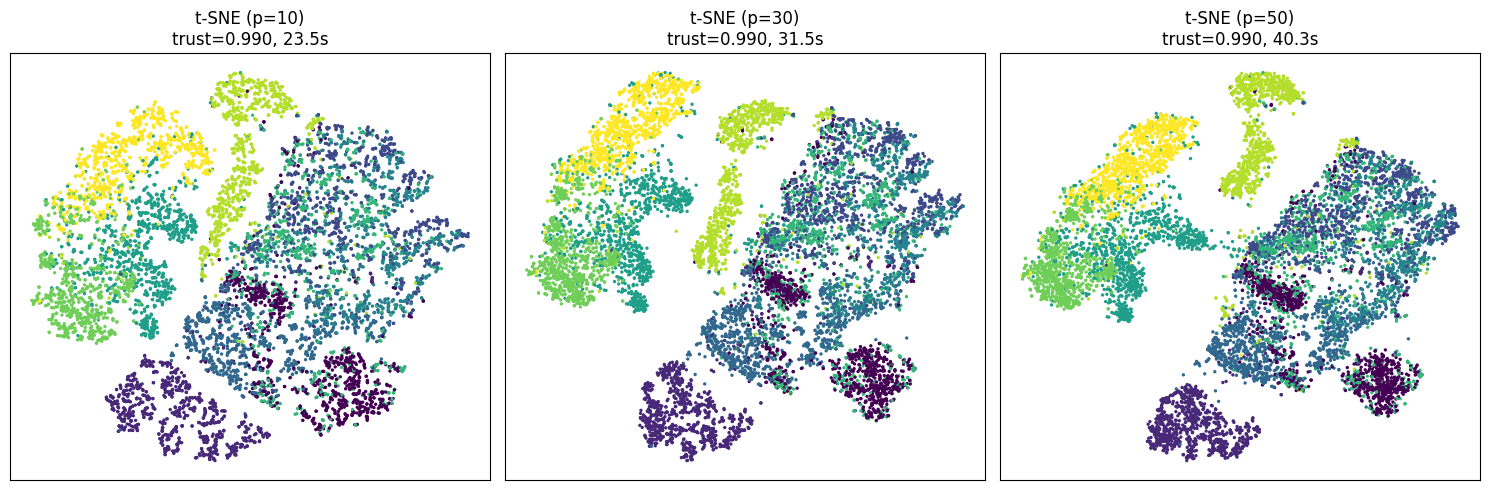

,method,trust,seconds
0,t-SNE_p10,0.989954,23.470739
1,t-SNE_p30,0.989917,31.472441
2,t-SNE_p50,0.989562,40.269060


In [22]:
from sklearn.manifold import TSNE, trustworthiness
import matplotlib.pyplot as plt
import pandas as pd
import time

perplexities = [10, 30, 50]
rows = []

fig, axes = plt.subplots(1, len(perplexities), figsize=(15,5))
for ax, p in zip(axes, perplexities):
    t0 = time.time()
    tsne = TSNE(n_components=2, perplexity=p, max_iter=1000,
                learning_rate="auto", init="pca", random_state=RANDOM_STATE)
    Z = tsne.fit_transform(X_vis)
    t1 = time.time()
    tw = trustworthiness(X_vis, Z, n_neighbors=10)
    rows.append(dict(method=f"t-SNE_p{p}", trust=tw, seconds=t1-t0))
    ax.scatter(Z[:,0], Z[:,1], c=y_vis, s=2)
    ax.set_title(f"t-SNE (p={p})\ntrust={tw:.3f}, {t1-t0:.1f}s")
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout(); plt.show()

tsne_df = pd.DataFrame(rows).sort_values(["trust","seconds"], ascending=[False, True])
tsne_df

C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\josea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


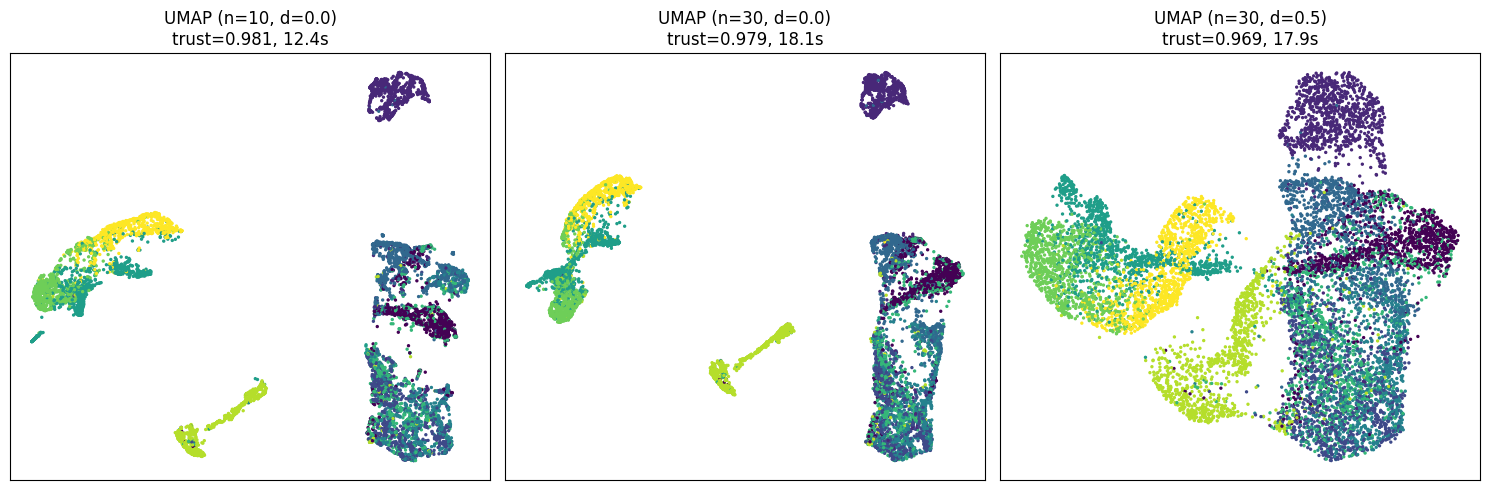

,method,trust,seconds
0,UMAP_n10_d0.0,0.981195,12.424148
1,UMAP_n30_d0.0,0.979257,18.100979
2,UMAP_n30_d0.5,0.969223,17.900282


In [23]:
import umap
from sklearn.manifold import trustworthiness
import matplotlib.pyplot as plt
import pandas as pd
import time

configs = [(10,0.0),(30,0.0),(30,0.5)]
rows = []

fig, axes = plt.subplots(1, len(configs), figsize=(15,5))
for ax, (nn, md) in zip(axes, configs):
    t0 = time.time()
    reducer = umap.UMAP(n_components=2, n_neighbors=nn, min_dist=md,
                        random_state=RANDOM_STATE, metric="euclidean")
    Z = reducer.fit_transform(X_vis)
    t1 = time.time()
    tw = trustworthiness(X_vis, Z, n_neighbors=10)
    rows.append(dict(method=f"UMAP_n{nn}_d{md}", trust=tw, seconds=t1-t0))
    ax.scatter(Z[:,0], Z[:,1], c=y_vis, s=2)
    ax.set_title(f"UMAP (n={nn}, d={md})\ntrust={tw:.3f}, {t1-t0:.1f}s")
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout(); plt.show()

umap_df = pd.DataFrame(rows).sort_values(["trust","seconds"], ascending=[False, True])
umap_df


### Resultados
Ambos métodos buscan preservar la **estructura local** de los datos en un espacio reducido.  
Se evaluaron distintas configuraciones y se midió la métrica **trustworthiness** (1 = vecindarios perfectamente conservados).

| Método / Parámetro | Trustworthiness | Tiempo (s) | Observaciones |
|:-------------------|:---------------:|:-----------:|:--------------|
| t-SNE (p=10) | 0.990 | 23.5 | Clústeres definidos pero fragmentados. |
| t-SNE (p=30) | 0.990 | 31.5 | Buen balance entre detalle local y global. |
| t-SNE (p=50) | 0.989 | 40.3 | Más difuso, sin mejora apreciable. |
| UMAP (n=10, d=0.0) | 0.981 | 12.4 | Grupos muy compactos, poca continuidad. |
| UMAP (n=30, d=0.0) | 0.979 | 18.1 | Separación clara y estructura estable. |
| UMAP (n=30, d=0.5) | 0.969 | 17.9 | Clases más dispersas, menor fidelidad. |

**Interpretación:**  
t-SNE mantiene alta preservación en todas las pruebas, siendo *perplexity = 30* el punto más equilibrado.  
UMAP logra resultados similares con menor tiempo; *n_neighbors = 30* y *min_dist = 0.0* ofrecen la mejor estructura.

### 2.3 “Para investigar”
**Spectral Embedding (Laplacian Eigenmaps)**: usa el espectro del grafo de vecinos para
obtener coordenadas que preservan la geometría del manifold local.

**Isomap**: aproxima distancias geodésicas sobre un grafo de vecinos y luego aplica MDS.
Ambos son útiles para datos en variedad no lineal. Igual que t-SNE/UMAP, aquí los usamos para 2D.
Parámetros clave: número de vecinos.


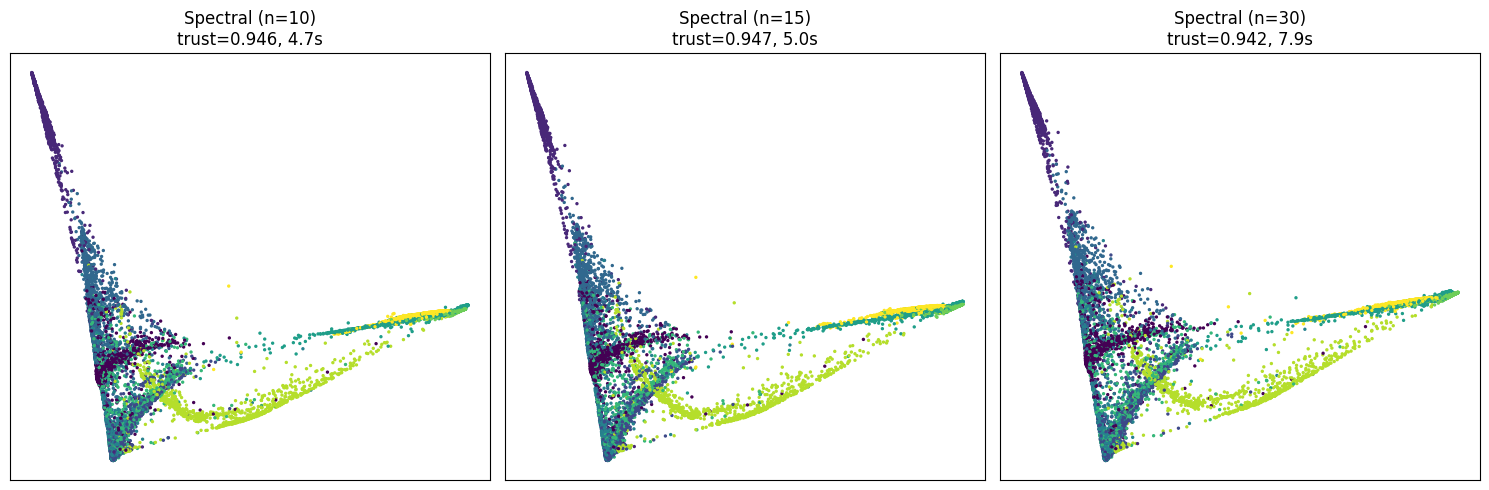

,method,trust,seconds
1,Spectral_n15,0.946545,5.049837
0,Spectral_n10,0.945786,4.666461
2,Spectral_n30,0.942211,7.857432


In [24]:
from sklearn.manifold import SpectralEmbedding, trustworthiness
import matplotlib.pyplot as plt
import pandas as pd
import time

# Subconjunto para visualización
X_vis, y_vis = sample_xy(train_X, train_y, n=10000, random_state=RANDOM_STATE)

spec_neighbors = [10, 15, 30]
rows = []
fig, axes = plt.subplots(1, len(spec_neighbors), figsize=(15,5))
for ax, nn in zip(axes, spec_neighbors):
    t0 = time.time()
    spec = SpectralEmbedding(n_components=2, n_neighbors=nn, random_state=RANDOM_STATE)
    Z = spec.fit_transform(X_vis)
    t1 = time.time()
    tw = trustworthiness(X_vis, Z, n_neighbors=10)
    rows.append(dict(method=f"Spectral_n{nn}", trust=tw, seconds=t1-t0))
    ax.scatter(Z[:,0], Z[:,1], c=y_vis, s=2)
    ax.set_title(f"Spectral (n={nn})\ntrust={tw:.3f}, {t1-t0:.1f}s")
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout(); plt.show()

spectral_df = pd.DataFrame(rows).sort_values(["trust","seconds"], ascending=[False, True])
spectral_df


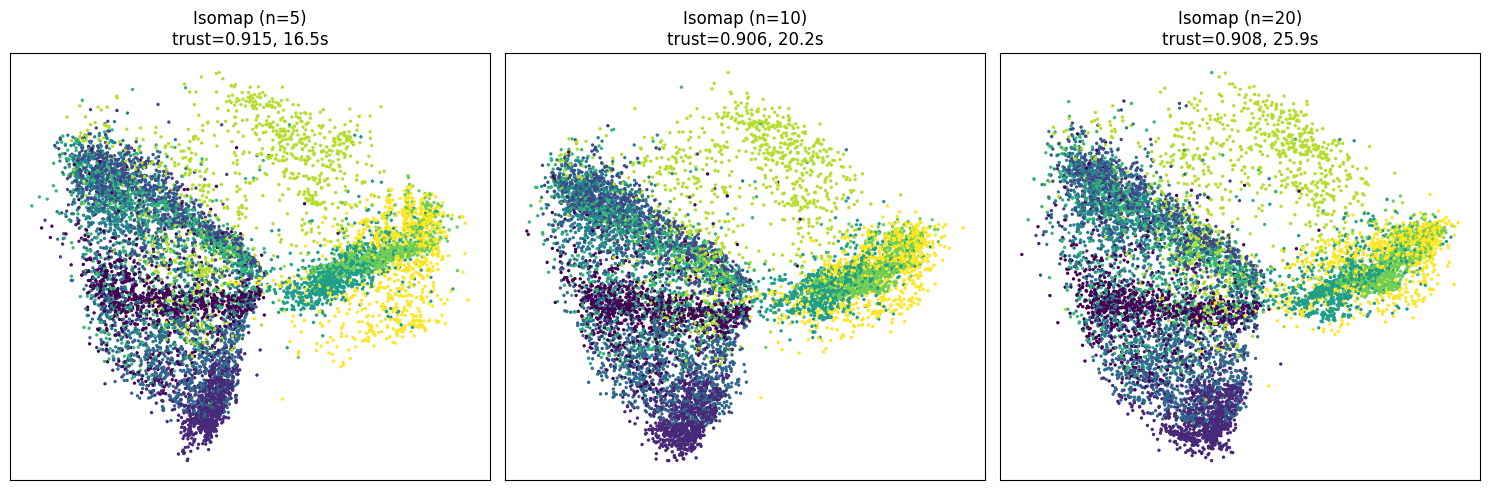

,method,trust,seconds
0,Isomap_n5,0.914702,16.492046
2,Isomap_n20,0.907663,25.875639
1,Isomap_n10,0.905534,20.242365


In [25]:
from sklearn.manifold import Isomap, trustworthiness
import matplotlib.pyplot as plt
import pandas as pd
import time

iso_neighbors = [5, 10, 20]
rows = []
fig, axes = plt.subplots(1, len(iso_neighbors), figsize=(15,5))
for ax, nn in zip(axes, iso_neighbors):
    t0 = time.time()
    iso = Isomap(n_neighbors=nn, n_components=2, metric="euclidean")
    Z = iso.fit_transform(X_vis)
    t1 = time.time()
    tw = trustworthiness(X_vis, Z, n_neighbors=10)
    rows.append(dict(method=f"Isomap_n{nn}", trust=tw, seconds=t1-t0))
    ax.scatter(Z[:,0], Z[:,1], c=y_vis, s=2)
    ax.set_title(f"Isomap (n={nn})\ntrust={tw:.3f}, {t1-t0:.1f}s")
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout(); plt.show()

isomap_df = pd.DataFrame(rows).sort_values(["trust","seconds"], ascending=[False, True])
isomap_df

### Resultados

| Método | n_neighbors | Trustworthiness | Tiempo (s) | Observaciones |
|:--------|:------------:|:---------------:|:-----------:|:--------------|
| Spectral Embedding | 10 | 0.946 | 4.7 | Agrupaciones coherentes, con ligera compresión. |
| Spectral Embedding | 15 | 0.947 | 5.0 | Mejor equilibrio local/global, clústeres definidos. |
| Spectral Embedding | 30 | 0.942 | 7.9 | Sin mejoras; mayor tiempo de cómputo. |
| Isomap | 5 | 0.915 | 16.5 | Clústeres nítidos pero algo fragmentados. |
| Isomap | 10 | 0.906 | 20.2 | Estructura más uniforme, menor confianza local. |
| Isomap | 20 | 0.908 | 25.9 | Similar desempeño, mayor costo computacional. |

**Interpretación:**  
- *Spectral Embedding* obtiene buena fidelidad local (trust ≈ 0.95) con bajo tiempo, siendo **n_neighbors = 15** la opción más estable.  
- *Isomap* alcanza trust ≈ 0.91 pero requiere mayor tiempo, ya que prioriza la estructura global del manifold.  


## Fase 3 · Clasificación y evaluación